In [85]:
# !pip install --upgrade google-cloud
# !pip install --upgrade google-cloud-bigquery
# !pip install --upgrade google-cloud-storage
# !pip install db-dtypes
# !pip install 'google-cloud-bigquery[pandas]'
# !pip install numpy
# !pip install pandas
# !pip install google.cloud
# !pip install scipy
# !pip install plotly
# !pip install seaborn
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 11.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 8.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [193]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes

def test(start_date, end_date,entity_d):

    query = f"""
            select   session_key
                    ,(case when sum(case when (eventAction = 'shop.clicked') or (eventAction = 'shop_details.loaded') then 1 else 0 end) > 0 Then 1 else 0 end) as vendor_page_opened
                    ,(case when sum(case when eventAction = 'transaction' then 1 else 0 end) > 0 Then 1 else 0 end) as transacted
                    ,AVG( case when 
    ROUND(
        COALESCE(
            CAST(
                NULLIF(
                    REGEXP_EXTRACT(
                        COALESCE(
                            json_value(eventVariables_json, "$.vendorDeliveryFee"),
                            json_value(eventVariables_json, "$.shopDeliveryFee")
                        ), 
                        r'([0-9]+\.?[0-9]*)'
                    ), 
                    ''
                ) AS FLOAT64
            ),
            0
        ),
    0)
) AS delivery_fee
                ,
                ,STD
            FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
            WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                    AND global_entity_id = 'MJM_AT'
                    --AND session_key = "SlXTIyTYecRbys2s4lOZUA=="
            group by 1
        """
    
    return query


# def test(start_date, end_date,entity_d):

#     query = f"""
#             select  
#                     AVG(
#                             ROUND(
#                                 COALESCE(
#                                     CAST(
#                                         NULLIF(
#                                             REGEXP_EXTRACT(
#                                                 COALESCE(
#                                                     json_value(eventVariables_json, "$.vendorDeliveryFee"),
#                                                     json_value(eventVariables_json, "$.shopDeliveryFee")
#                                                 ), 
#                                                 r'([0-9]+\.?[0-9]*)'
#                                             ), 
#                                             ''
#                                         ) AS FLOAT64
#                                     ),
#                                     0
#                                 ),
#                             0)
#                         ) AS delivery_fee
#                     ,(case when sum(case when (eventAction = 'shop.clicked') or (eventAction = 'shop_details.loaded') then 1 else 0 end) > 0 Then 1 else 0 end) as vendor_page_opened
#                     ,(case when sum(case when eventAction = 'transaction' then 1 else 0 end) > 0 Then 1 else 0 end) as transacted
                    
#             FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
#             WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#                     AND global_entity_id = 'MJM_AT'
#                     --AND session_key = "SlXTIyTYecRbys2s4lOZUA=="
#             group by 1
#         """
    
#     return query


def impression_details():

    query = f"""
    with listing as (
        select  global_entity_id
            ,session_key
            ,perseus_session_id
            ,shopId
            ,df_impressions
        from (
        SELECT  session_key
                ,COALESCE(pe.global_entity_id,json_value(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key,shopId ORDER BY event_timestamp_local) row_num
                ,COALESCE(shopId,json_value(eventVariables_json, "$.shopId") ) AS shopId
                ,coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")) df_raw
                ,coalesce(CAST(NULLIF(REGEXP_EXTRACT(coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")),  r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64),0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` pe
        WHERE partition_date BETWEEN '2024-06-01' and '2024-06-03'
                AND eventAction = 'shop_impressions.loaded'
                AND screenType = 'shop_list'
                AND pe.global_entity_id IN ('MJM_AT')
                --AND session_key = "+1AKPADvqmx7KBN0FLfpxw=="
        )
        where row_num = 1
        and df_raw is not null
        order by global_entity_id,session_key

        ), shop_details as (
        select  global_entity_id
            ,session_key
            ,perseus_session_id
            ,shopId
            ,df_impressions
        from (
        SELECT  session_key
                ,COALESCE(global_entity_id,json_value(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key,shopId ORDER BY event_timestamp_local) row_num
                ,COALESCE(shopId,json_value(eventVariables_json, "$.shopId") ) AS shopId
                ,coalesce(CAST(NULLIF(REGEXP_EXTRACT(coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")),  r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64),0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN '2024-06-01' and '2024-06-03'
                AND ((screenType = 'shop_list' AND eventAction = 'shop.clicked') OR (screenType = 'shop_details' AND eventAction IN ('shop_details.loaded','menu_tab.clicked')))
                AND global_entity_id IN ('MJM_AT')
                --AND session_key = "+1AKPADvqmx7KBN0FLfpxw=="
        )
        where row_num = 1
        order by global_entity_id,session_key
        ), orders as (
        select  global_entity_id
            ,session_key
            ,perseus_session_id
            ,shopId
            ,df_impressions
        from (
        SELECT  session_key
                ,COALESCE(global_entity_id,json_value(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key,shopId ORDER BY event_timestamp_local) row_num
                ,COALESCE(shopId,json_value(eventVariables_json, "$.shopId") ) AS shopId
                ,coalesce(CAST(NULLIF(REGEXP_EXTRACT(coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")),  r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64),0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN '2024-06-01' and '2024-06-03'
                AND eventAction IN ('transaction')
                AND global_entity_id IN ('MJM_AT')
                --AND session_key = "+1AKPADvqmx7KBN0FLfpxw=="
        )
        where row_num = 1
        order by global_entity_id,session_key
        )
        select  l.global_entity_id
            ,l.session_key
            ,l.perseus_session_id
            ,l.shopId
            ,l.df_impressions delivery_fee_listing
            ,sd.df_impressions delivery_fee_details
            ,o.df_impressions delivery_fee_order
            ,coalesce(l.df_impressions,sd.df_impressions,o.df_impressions) delivery_fee
            ,(case when sd.session_key is not null then 1 else 0 end) converted_details_page
            ,(case when o.session_key is not null then 1 else 0 end) converted_order
        from listing l
        left join shop_details sd on sd.global_entity_id = l.global_entity_id and sd.session_key = l.session_key and sd.shopId = l.shopId
        left join orders o on o.global_entity_id = l.global_entity_id and o.session_key = l.session_key and o.shopId = l.shopId
    """

    return query

<>:38: SyntaxWarning: invalid escape sequence '\.'
<>:170: SyntaxWarning: invalid escape sequence '\.'
<>:38: SyntaxWarning: invalid escape sequence '\.'
<>:170: SyntaxWarning: invalid escape sequence '\.'
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_78289/1157477869.py:38: SyntaxWarning: invalid escape sequence '\.'
  WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_78289/1157477869.py:170: SyntaxWarning: invalid escape sequence '\.'
  """


<Axes: xlabel='delivery_fee_listing_rounded', ylabel='conversion'>

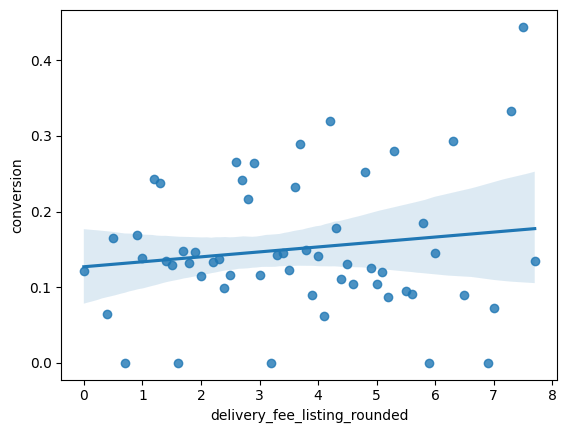

In [311]:
details['delivery_fee_listing_rounded'] = details['delivery_fee_listing'].round(1)

# Group by 'delivery_fee_listing' and aggregate
listing = details.groupby('delivery_fee_listing_rounded').agg(
    converted_details_page_sum=('converted_details_page', 'sum'),
    shopId_count=('shopId', 'count')
).reset_index()


# Rename columns
listing.columns = ['delivery_fee_listing_rounded', 'conversion_detail', 'total_vendors']

listing['conversion'] = listing['conversion_detail'] / listing['total_vendors']

listing = listing[listing['delivery_fee_listing_rounded'] < 8]

sns.regplot(data=listing, x = 'delivery_fee_listing_rounded',y = 'conversion')

In [295]:
details

,global_entity_id,session_key,perseus_session_id,shopId,delivery_fee_listing,delivery_fee_details,delivery_fee_order,delivery_fee,converted_details_page,converted_order,delivery_fee_listing_rounded,delivery_fee_details_rounded
0,MJM_AT,+6AkfqjcNlo2cvlX8uoNeQ==,1717339555343.4193859015.imdyochyss,um9z,1.79,NaN,NaN,1.79,0,0,2.0,NaN
1,MJM_AT,+GKCd2x3i3LcVaQTCvtlTg==,1717338792805.6513431650.smxeevwatv,ef9s,1.50,NaN,NaN,1.50,0,0,2.0,NaN
2,MJM_AT,+OjYTMmZoZp40qDqeZXrYA==,1717248238160.587215113553837323.ZiSV5Xm7hK,df44,1.79,NaN,NaN,1.79,0,0,2.0,NaN
3,MJM_AT,+VxyfdQafWyqYUrfm+E6Eg==,1717346270089.632243591680767971.fuc8t5HEmi,q9jb,2.29,NaN,NaN,2.29,0,0,2.0,NaN
4,MJM_AT,+Wh5TUGRgsPrw86GBV8bdw==,1717346845696.821394941438463923.WIdAJiVxjG,l33x,1.79,NaN,NaN,1.79,0,0,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2231216,MJM_AT,zYMkXkT+uTLra8vh9mwf7w==,1717254189986.8389972013.kpxwofvnuf,y90n,5.49,NaN,NaN,5.49,0,0,5.0,NaN
2231217,MJM_AT,zb08AQOleIWjTCl5ULNriQ==,1717424489564.1120991483.rqikrgjtfi,iuqx,5.49,NaN,NaN,5.49,0,0,5.0,NaN
2231218,MJM_AT,zmBso11cjQ7gV9pQXkEqsQ==,1717262008370.494705789933921394.06Vi9sZrMI,xvrh,5.49,NaN,NaN,5.49,0,0,5.0,NaN
2231219,MJM_AT,zn38AjGIjd92VhNh6liDvQ==,1717345801360.703060334509614828.MYz82LTlUN,ock4,5.49,NaN,NaN,5.49,0,0,5.0,NaN


<Axes: xlabel='delivery_fee_details_rounded', ylabel='conversion'>

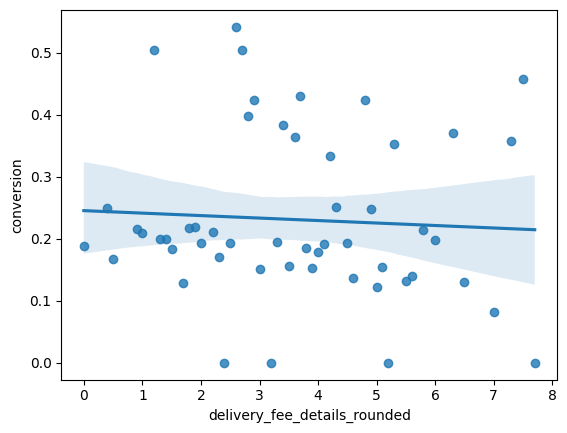

In [312]:
details['delivery_fee_details_rounded'] = details['delivery_fee_details'].round(1)

# Group by 'delivery_fee_listing' and aggregate
listing = details.groupby('delivery_fee_details_rounded').agg(
    converted_details_page_sum=('converted_order', 'sum'),
    shopId_count=('converted_details_page', 'sum')
).reset_index()


# Rename columns
listing.columns = ['delivery_fee_details_rounded', 'converted_order', 'converted_details_page']

listing['conversion'] = listing['converted_order'] / listing['converted_details_page']

listing = listing[listing['delivery_fee_details_rounded'] < 20]

sns.regplot(data=listing, x = 'delivery_fee_details_rounded',y = 'conversion')

In [194]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

start_date = '2024-06-01'
end_date = '2024-06-07'

# entity_id = 'DJ_CZ','FO_NO','MJM_AT','NP_HU','OP_SE','PO_FI','YS_TR','EF_GR','FY_CY','FP_BD','FP_HK','FP_KH','FP_LA','FP_MM','FP_MY','FP_PH','FP_PK','FP_SG','FP_TH','FP_TW','HS_SA','AP_PA','PY_AR','PY_BO','PY_CL','PY_CR','PY_DO','PY_EC','PY_GT','PY_HN','PY_NI','PY_PE','PY_PY','PY_SV','PY_UY','PY_VE','HF_EG','TB_AE',
# 'TB_BH','TB_IQ','TB_JO','TB_KW','TB_OM','TB_QA'

entity_id = 'MJM_AT'
entity_id_str = ",".join([f"'{entity}'" for entity in entity_id])

# match_details_df = client.query(test(start_date, end_date,entity_id_str)).to_dataframe()

details = client.query(impression_details()).to_dataframe()

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [195]:
# group data on session level
result = details.groupby('session_key').agg({
    'shopId': 'count',
    'delivery_fee_listing': ['min', 'max', 'mean', 'std'],
    'delivery_fee_details': ['min', 'max', 'mean', 'std'],
    'delivery_fee_order': ['min', 'max', 'mean', 'std'],
    'converted_details_page': 'sum',
    'converted_order':'sum'
})

result = result.reset_index()

result.columns = ['session_keys','shopId_count', 'delivery_fee_listing_min', 'delivery_fee_listing_max', 'delivery_fee_listing_mean', 'delivery_fee_listing_std', 
                  'delivery_fee_details_min', 'delivery_fee_details_max', 'delivery_fee_details_mean', 'delivery_fee_details_std', 
                  'delivery_fee_order_min', 'delivery_fee_order_max', 'delivery_fee_order_mean', 'delivery_fee_order_std'
                  ,'conversion_details','conversion_order']


result = result[['session_keys','shopId_count', 'delivery_fee_listing_mean', 'delivery_fee_details_mean', 'delivery_fee_order_mean','delivery_fee_listing_std',
                 'delivery_fee_details_std','delivery_fee_order_std','delivery_fee_listing_max','delivery_fee_details_max','delivery_fee_order_max',
                 'delivery_fee_listing_min','delivery_fee_details_min','delivery_fee_order_min','conversion_details','conversion_order']]


# #data checks to ensure two orders are not being created for the same session
# # a = result[result['conversion_order'] > 1]['session_key']
# # a_df = a.to_frame()
# # a_df.to_csv('session_keys.csv', index=False)

# #details[(details['session_key'] == '+7rRdfTKaQno5YS6X1z+MA==') & (details['converted_order'] == 1)]


#remove sessions with more than 1 order creation (temp)
result = result[result['conversion_order'] <= 1]

print(result)


                    session_keys  shopId_count  delivery_fee_listing_mean  \
0       ++0u55IlaYPsh5wAfZTNXg==             1                   3.990000   
1       ++0xEtmHqih2U+sT8OT/pQ==             1                   3.290000   
2       ++1DJl6j/Zjf25F4UmwaCw==            15                   2.358000   
3       ++3qw6Gtw71WK7IfeP6kag==             3                   2.160000   
4       ++AopSze1dRD4kppw9bQOg==             3                   0.830000   
...                          ...           ...                        ...   
138890  zzmCZFn1NOTBZVvuqhx8HQ==            12                   3.220000   
138891  zznGUanBZgDc4SOHi481wA==            47                   2.979149   
138892  zzphDo4pnF1oodvblfAKCA==            27                   2.758148   
138893  zztkUEeB7sy6TUmICqNOSA==            10                   2.082000   
138894  zzvEVtLsr1a+p1+/FdYu/A==             2                   2.490000   

        delivery_fee_details_mean  delivery_fee_order_mean  \
0            

In [198]:
descriptive_stats = result.describe()

descriptive_stats.transpose().style \
                 .format(precision=2, thousands=",", decimal=".") \
                 .format_index(str.upper, axis=1)

,COUNT,MEAN,STD,MIN,25%,50%,75%,MAX
shopId_count,"138,007.00",15.95,23.82,1.00,3.00,8.00,20.00,854.00
delivery_fee_listing_mean,"138,007.00",2.45,0.92,0.00,1.95,2.49,2.99,7.49
delivery_fee_details_mean,"101,437.00",2.10,1.45,0.00,0.99,2.37,3.00,7.49
delivery_fee_order_mean,"49,013.00",1.24,1.62,0.00,0.00,0.00,2.49,10.19
delivery_fee_listing_std,"123,826.00",1.37,0.60,0.00,1.04,1.39,1.76,8.52
delivery_fee_details_std,"48,650.00",1.15,0.84,0.00,0.45,1.15,1.75,5.30
delivery_fee_order_std,0.00,nan,nan,nan,nan,nan,nan,nan
delivery_fee_listing_max,"138,007.00",4.09,1.30,0.00,3.49,4.00,4.99,45.00
delivery_fee_details_max,"101,437.00",2.66,1.73,0.00,0.99,2.99,3.99,7.70
delivery_fee_order_max,"49,013.00",1.24,1.62,0.00,0.00,0.00,2.49,10.19


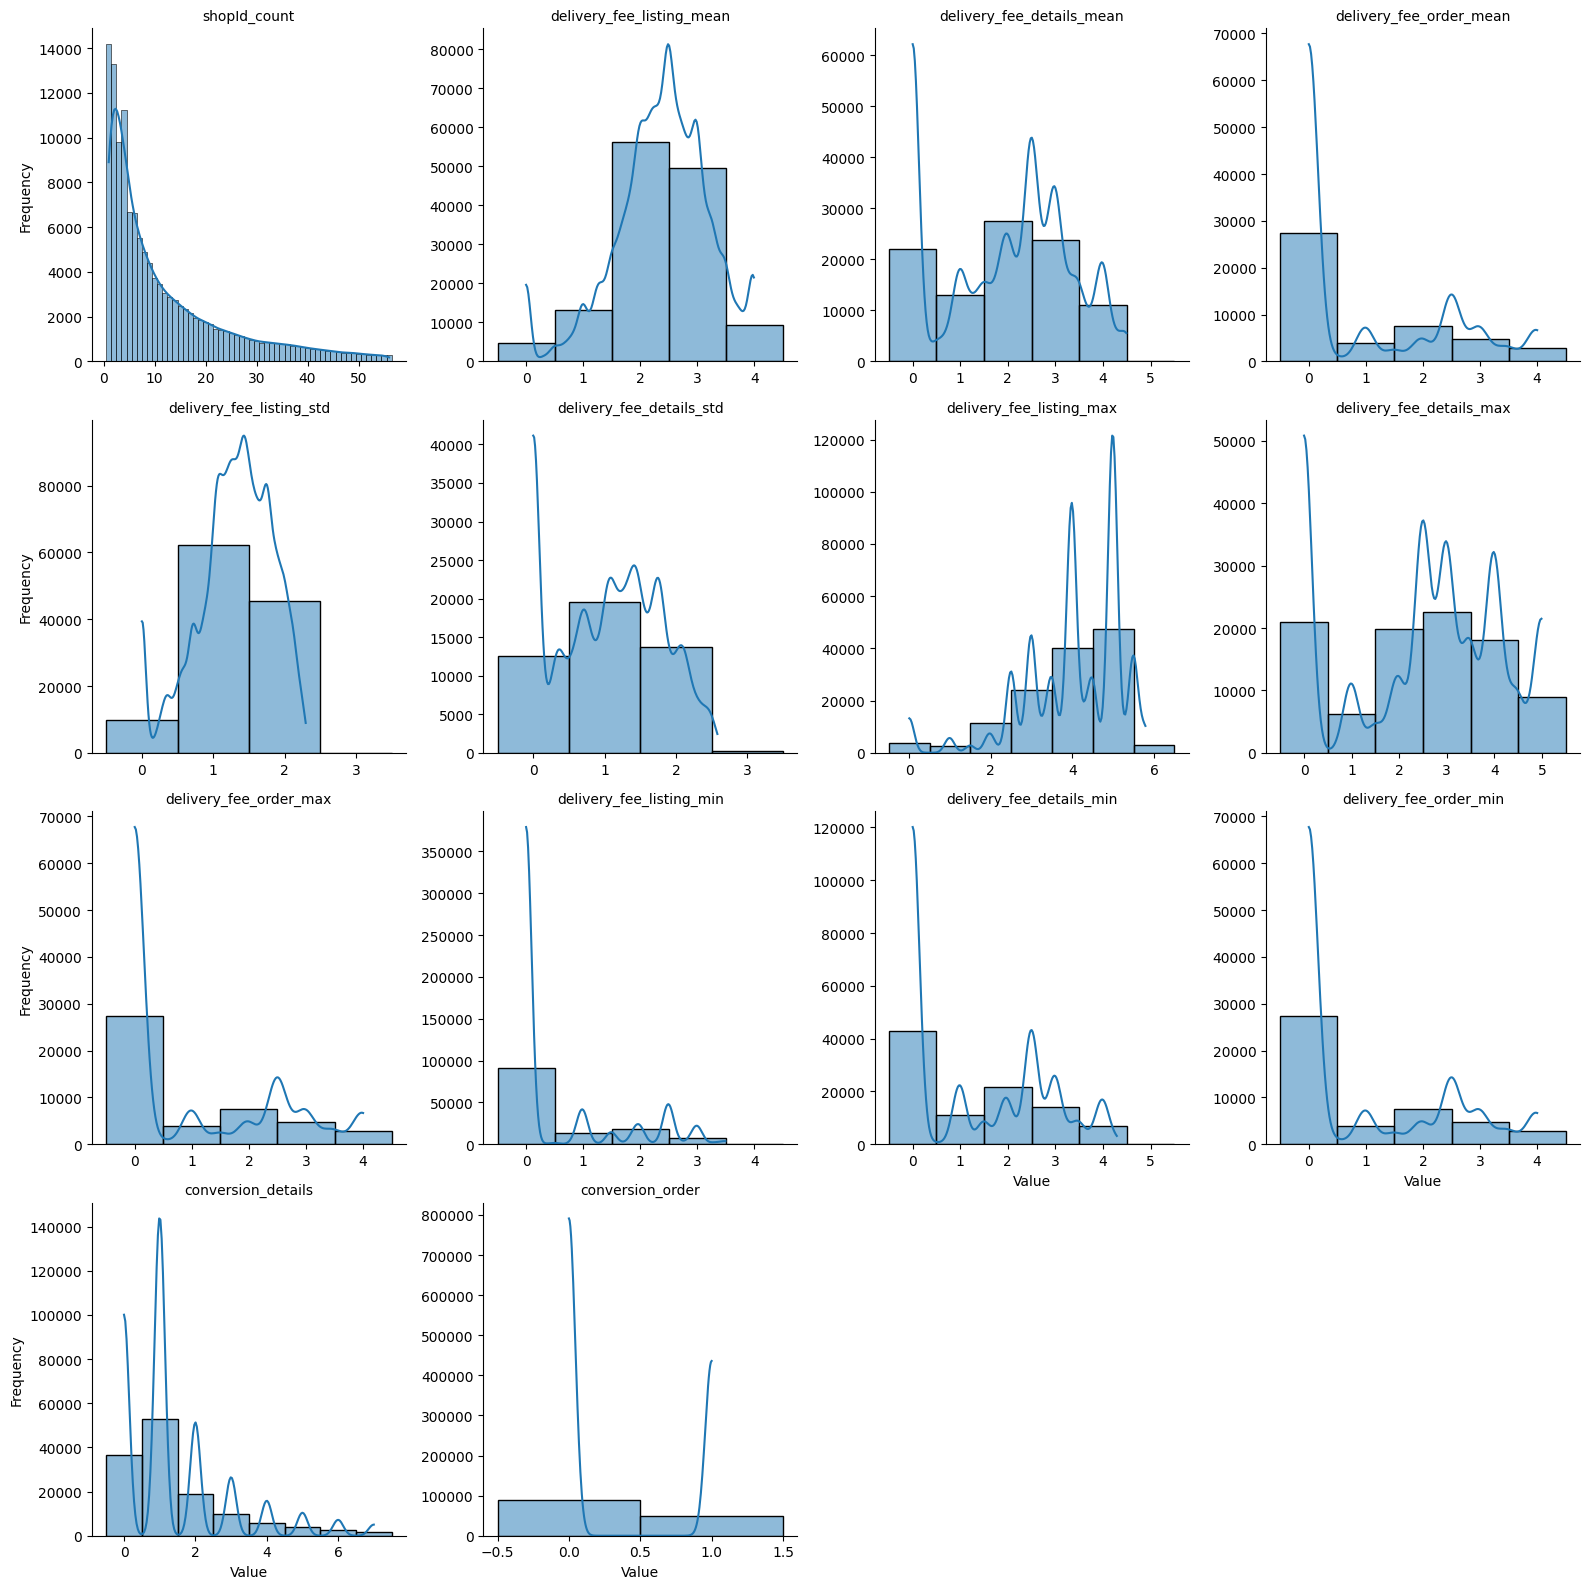

In [199]:
#session level summary stats

long_df = pd.melt(result)

long_df = long_df[~long_df['variable'].isin(['session_keys'])]

long_df['value'] = long_df['value'].astype(float)

percentiles = long_df.groupby('variable')['value'].quantile(0.95).reset_index()
percentiles.rename(columns={'value': '95th_percentile'}, inplace=True)

long_df = pd.merge(long_df, percentiles, on='variable')

long_df = long_df[long_df['value'] <= long_df['95th_percentile']]

g = sns.FacetGrid(long_df, col="variable", col_wrap=4, height=4, sharex=False, sharey=False)

g.map(sns.histplot, "value", kde=True, discrete=True)

g.set_titles("{col_name}")
g.set_axis_labels("Value", "Frequency")
plt.tight_layout()

# Show the plot
plt.show()

In [210]:
result.isna().sum()

result['delivery_fee_listing_std'] = result['delivery_fee_listing_std'].fillna(0)

result['converted_to_details'] = result['conversion_details'].apply(lambda x: 1 if x > 0 else 0)
result['converted_to_order'] = result['conversion_order'].apply(lambda x: 1 if x > 0 else 0)

import statsmodels.api as sm

X = result[['delivery_fee_listing_mean','delivery_fee_listing_max','delivery_fee_listing_min','delivery_fee_listing_std']] 
y = result['converted_to_details']

X = sm.add_constant(X)

model = sm.Logit(y, X)
mode_output = model.fit()

print(mode_output.summary())


Optimization terminated successfully.
         Current function value: 0.533508
         Iterations 6
                            Logit Regression Results                            
Dep. Variable:     converted_to_details   No. Observations:               138007
Model:                            Logit   Df Residuals:                   138002
Method:                             MLE   Df Model:                            4
Date:                  Tue, 20 Aug 2024   Pseudo R-squ.:                 0.07731
Time:                          14:11:12   Log-Likelihood:                -73628.
converged:                         True   LL-Null:                       -79797.
Covariance Type:              nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0941      0.020      4.640    

In [226]:
ab = result[result['converted_to_details'] != 0]

ab.isna().sum()

session_keys                      0
shopId_count                      0
delivery_fee_listing_mean         0
delivery_fee_details_mean         0
delivery_fee_order_mean       52669
delivery_fee_listing_std          0
delivery_fee_details_std      52787
delivery_fee_order_std       101437
delivery_fee_listing_max          0
delivery_fee_details_max          0
delivery_fee_order_max        52669
delivery_fee_listing_min          0
delivery_fee_details_min          0
delivery_fee_order_min        52669
conversion_details                0
conversion_order                  0
converted_to_details              0
converted_to_order                0
dtype: int64

In [227]:
ab.isna().sum()

ab['delivery_fee_details_std'] = ab['delivery_fee_listing_std'].fillna(0)

import statsmodels.api as sm

X = ab[['delivery_fee_details_mean','delivery_fee_details_max','delivery_fee_details_min','delivery_fee_details_std']] 
y = ab['converted_to_order']

X = sm.add_constant(X)

model = sm.Logit(y, X)
mode_output = model.fit()

print(mode_output.summary())

Optimization terminated successfully.
         Current function value: 0.692276
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:     converted_to_order   No. Observations:               101437
Model:                          Logit   Df Residuals:                   101432
Method:                           MLE   Df Model:                            4
Date:                Tue, 20 Aug 2024   Pseudo R-squ.:               0.0001895
Time:                        14:34:46   Log-Likelihood:                -70222.
converged:                       True   LL-Null:                       -70236.
Covariance Type:            nonrobust   LLR p-value:                 2.376e-05
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.1263      0.017     -7.528      0.000      -0.

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_78289/2852658395.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ab['delivery_fee_details_std'] = ab['delivery_fee_listing_std'].fillna(0)


Optimization terminated successfully.
         Current function value: 0.533959
         Iterations 6
                            Logit Regression Results                            
Dep. Variable:     converted_to_details   No. Observations:                96604
Model:                            Logit   Df Residuals:                    96599
Method:                             MLE   Df Model:                            4
Date:                  Tue, 20 Aug 2024   Pseudo R-squ.:                 0.07744
Time:                          13:52:46   Log-Likelihood:                -51583.
converged:                         True   LL-Null:                       -55912.
Covariance Type:              nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0792      0.024      3.261    

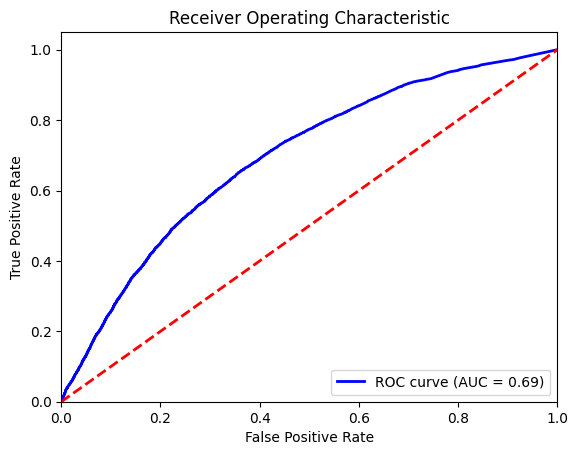

AUC: 0.6936740134543308


In [208]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import statsmodels.api as sm

X = result[['delivery_fee_listing_mean','delivery_fee_listing_max','delivery_fee_listing_min','delivery_fee_listing_std']] 
y = result['converted_to_details']

# Assuming `result` is your DataFrame and `X` and `y` are already defined
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Add constant to the model (intercept)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Train the logistic regression model on the training set
model = sm.Logit(y_train, X_train)
model_output = model.fit()

# Print model summary
print(model_output.summary())

# Predict on the test set
y_pred_prob = model_output.predict(X_test)
y_pred_class = y_pred_prob.apply(lambda x: 1 if x > 0.5 else 0)

# 1. Evaluate model performance on the test set

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# 2. Plot the ROC Curve and calculate AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print AUC value
print(f"AUC: {roc_auc}")


In [216]:
import statsmodels.api as sm

X = details[['delivery_fee_listing']] 
y = details['converted_details_page']

X = sm.add_constant(X)

model = sm.Logit(y, X)
mode_output = model.fit()

print(mode_output.summary())

Optimization terminated successfully.
         Current function value: 0.371327
         Iterations 6
                             Logit Regression Results                             
Dep. Variable:     converted_details_page   No. Observations:              2231221
Model:                              Logit   Df Residuals:                  2231219
Method:                               MLE   Df Model:                            1
Date:                    Tue, 20 Aug 2024   Pseudo R-squ.:               6.435e-05
Time:                            14:21:02   Log-Likelihood:            -8.2851e+05
converged:                           True   LL-Null:                   -8.2857e+05
Covariance Type:                nonrobust   LLR p-value:                 5.347e-25
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.9395      0.004   -524.818   

In [230]:
ss = details[~details['delivery_fee_details'].isna()]

In [318]:
ss

,global_entity_id,session_key,perseus_session_id,shopId,delivery_fee_listing,delivery_fee_details,delivery_fee_order,delivery_fee,converted_details_page,converted_order,log_df,ll
14,MJM_AT,/AYSWSphAC16mWrx2Ure0A==,1717258397846.391718657660423271.p6dqq7XXxR,zzs7,3.79,3.79,NaN,3.79,1,0,1.332366,1.332366
31,MJM_AT,0G0+6KopSI3SISXJTbmwxA==,1717445704613.985845258422616033.siFPGrfp1G,xi3m,3.79,3.79,0.00,3.79,1,1,1.332366,1.332366
33,MJM_AT,0NRMpi3v38axdmaIwvsuNw==,1717435000725.148982286106836569.H7wgTbhpwT,tz4r,6.99,6.99,NaN,6.99,1,0,1.944481,1.944481
38,MJM_AT,0mYFFc7QpOZG2sNxYDxR2A==,1717414184863.912713094057223009.qhb4QWrFqV,xdo5,2.59,0.00,0.00,2.59,1,1,NaN,NaN
53,MJM_AT,1YdQ7WZTfCnpVhkNISTi0A==,1717441421895.5540186513.asalfqvktu,cfl3,5.99,5.99,5.99,5.99,1,1,1.790091,1.790091
...,...,...,...,...,...,...,...,...,...,...,...,...
2231155,MJM_AT,qMC+VGUw93TU3LIqggn/LA==,1717260876862.9149297801.rydluoiyor,cfx0,5.49,5.49,NaN,5.49,1,0,1.702928,1.702928
2231164,MJM_AT,rJQ7dBUqtqypAmiOa9AODg==,1717406955341.100185064914897033.X3bcTSapBh,iihv,5.49,5.49,NaN,5.49,1,0,1.702928,1.702928
2231183,MJM_AT,u8A1uhxLv+xrvCRrLkp0ww==,1717423238010.2021671169.owprpfbckk,kgo1,5.49,5.49,NaN,5.49,1,0,1.702928,1.702928
2231191,MJM_AT,w3r93nupVHIv18WCeLlF5g==,1717253511657.875363236466525691.fTYJD4IIX7,k2gy,5.49,5.49,NaN,5.49,1,0,1.702928,1.702928


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_78289/344127642.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ss['ll'] = ss['delivery_fee_details'].apply(safe_log)


Optimization terminated successfully.
         Current function value: 0.478717
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:        converted_order   No. Observations:               272729
Model:                          Logit   Df Residuals:                   272727
Method:                           MLE   Df Model:                            1
Date:                Wed, 21 Aug 2024   Pseudo R-squ.:               0.0007855
Time:                        14:08:04   Log-Likelihood:            -1.3056e+05
converged:                       True   LL-Null:                   -1.3066e+05
Covariance Type:            nonrobust   LLR p-value:                 1.486e-46
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3969      0.008   -182.993      0.000      -1.412      -1.382
ll            -0.1191      0.

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_78289/344127642.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ss['predicted_prob'] = model_output.predict(X)


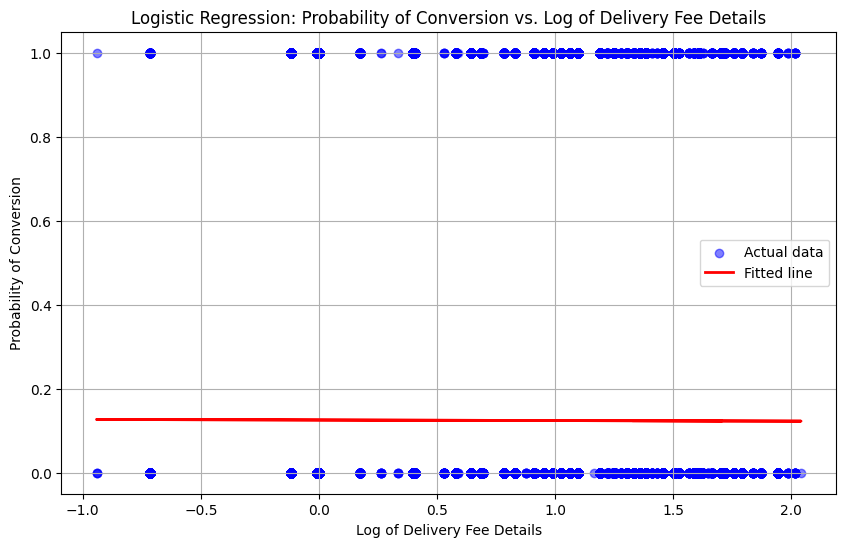

In [320]:
import statsmodels.api as sm

# Define a function to apply logarithm only to non-zero values
def safe_log(x):
    return np.log(x) if x > 0 else 0

ss['ll'] = ss['delivery_fee_details'].apply(safe_log)

X = ss[['ll']] 
y = ss['converted_order']

X = sm.add_constant(X)

model = sm.Logit(y, X)
mode_output = model.fit()

print(mode_output.summary())

<Axes: xlabel='delivery_fee_details', ylabel='converted_order'>

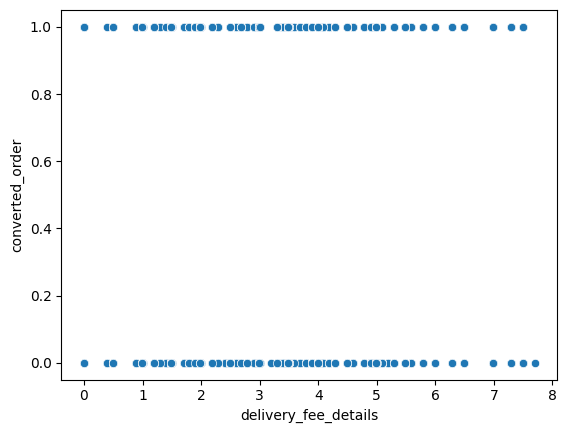

In [232]:
sns.scatterplot(data=ss, x="delivery_fee_details", y="converted_order")

In [241]:
model_output.params

const                  -1.940911
delivery_fee_listing   -0.012216
dtype: float64

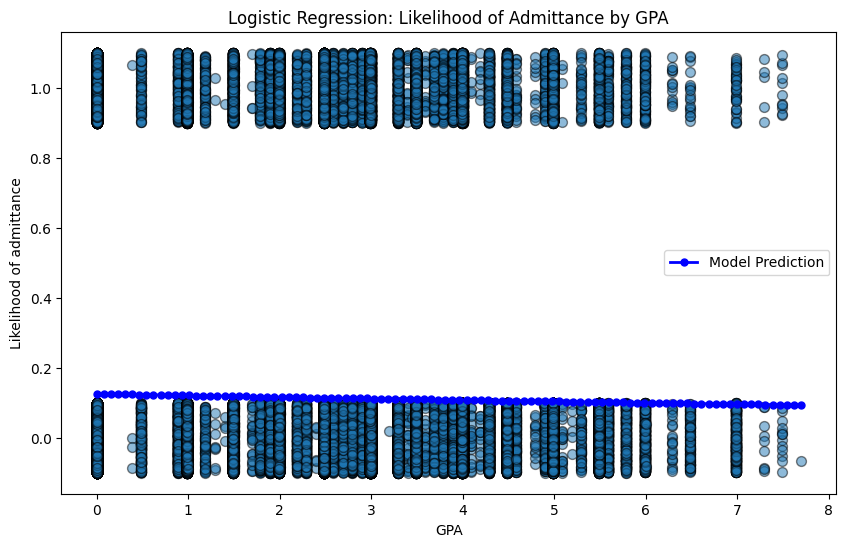

In [242]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit  # This is the inverse logit function

# Assuming 'result' is your DataFrame and 'model_output' is the fitted model

# Define the inverse logit function (expit)
def inverselogit(x):
    return expit(x)

# Assuming 'gpa' is the feature you are plotting against and 'converted_to_details' is the outcome
gpa = ss['delivery_fee_details']  
converted = ss['converted_order'] 

# Plot the actual data points with jitter
plt.figure(figsize=(10, 6))
plt.scatter(gpa, converted + np.random.uniform(-0.1, 0.1, size=len(converted)), alpha=0.5, edgecolor='k', s=50)
plt.xlabel('GPA')  # Replace 'GPA' with the correct label if using another feature
plt.ylabel('Likelihood of admittance')

# Get the coefficients from the fitted model
intercept = model_output.params['const']
slope = -0.0431 

# Generate a range of GPA values to predict
gpa_range = np.linspace(gpa.min(), gpa.max(), 100)

# Calculate the predicted probabilities for this range
predicted_probabilities = inverselogit(intercept + slope * gpa_range)

# Plot the model prediction line
plt.plot(gpa_range, predicted_probabilities, color='blue', linewidth=2, marker='o', markersize=5, label='Model Prediction')

# Add a legend
plt.legend()

# Show the plot
plt.title('Logistic Regression: Likelihood of Admittance by GPA')
plt.show()

Optimization terminated successfully.
         Current function value: 0.371439
         Iterations 6
                             Logit Regression Results                             
Dep. Variable:     converted_details_page   No. Observations:              1561854
Model:                              Logit   Df Residuals:                  1561852
Method:                               MLE   Df Model:                            1
Date:                    Tue, 20 Aug 2024   Pseudo R-squ.:               5.672e-05
Time:                            13:53:41   Log-Likelihood:            -5.8013e+05
converged:                           True   LL-Null:                   -5.8017e+05
Covariance Type:                nonrobust   LLR p-value:                 4.953e-16
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.9409      0.004   -439.280   

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8778965799031024
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


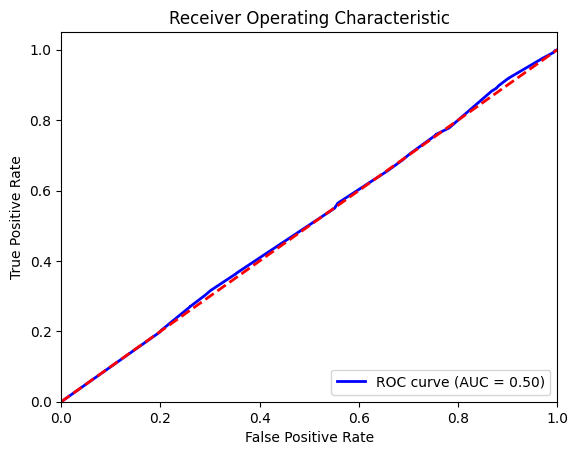

AUC: 0.5046318250988563


In [209]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import statsmodels.api as sm

X = details[['delivery_fee_listing']] 
y = details['converted_details_page']

# Assuming `result` is your DataFrame and `X` and `y` are already defined
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Add constant to the model (intercept)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Train the logistic regression model on the training set
model = sm.Logit(y_train, X_train)
model_output = model.fit()

# Print model summary
print(model_output.summary())

# Predict on the test set
y_pred_prob = model_output.predict(X_test)
y_pred_class = y_pred_prob.apply(lambda x: 1 if x > 0.5 else 0)

# 1. Evaluate model performance on the test set

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# 2. Plot the ROC Curve and calculate AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print AUC value
print(f"AUC: {roc_auc}")


In [202]:
# import numpy as np
# import pandas as pd
# from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
# import statsmodels.api as sm
# import matplotlib.pyplot as plt


# # Predict the probabilities
# y_pred_prob = mode_output.predict(X)

# # Convert probabilities to binary output (threshold = 0.5)
# y_pred = np.where(y_pred_prob >= 0.5, 1, 0)

# # Confusion Matrix
# conf_matrix = confusion_matrix(y, y_pred)
# print("Confusion Matrix:\n", conf_matrix)

# # Accuracy
# accuracy = accuracy_score(y, y_pred)
# print("Accuracy:", accuracy)

# # Precision
# precision = precision_score(y, y_pred)
# print("Precision:", precision)

# # Recall
# recall = recall_score(y, y_pred)
# print("Recall:", recall)

# # F1-Score
# f1 = f1_score(y, y_pred)
# print("F1-Score:", f1)

# # ROC-AUC Score
# roc_auc = roc_auc_score(y, y_pred_prob)
# print("ROC-AUC Score:", roc_auc)

# # Plotting the ROC Curve
# fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
# plt.figure()
# plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()

In [183]:
details

,global_entity_id,session_key,perseus_session_id,shopId,category_id,delivery_fee_listing,delivery_fee_details,delivery_fee_order,delivery_fee,converted_details_page,converted_order,rounded
0,MJM_AT,+Qk1Mi7I1kFmwcjhFt2l5A==,1717239117528.7103557385.vgjvailvvn,eha9,027,1.79,NaN,NaN,1.79,0,0,2.0
1,MJM_AT,+iQIUo4+m4p+iy6L6Zv99A==,1717270402483.1604755945.shyuvqsfqx,va6r,064,2.49,0.00,NaN,2.49,1,0,2.0
2,MJM_AT,0Qw8hcC+sZxc+R1v9NFYuw==,1717265437448.4317314887.ixzgbiflec,aa4b,038,3.99,NaN,NaN,3.99,0,0,4.0
3,MJM_AT,0a+NGmsNMf/qRsWBlXDYVQ==,1717332755363.693426670240550323.nyf5kloWwB,y955,047,2.49,NaN,NaN,2.49,0,0,2.0
4,MJM_AT,0tc6Z1E04o+1hOfYyC688w==,1717260777157.2152830052.smcrlmuyth,lp35,092,0.00,NaN,NaN,0.00,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2191830,MJM_AT,jhsHQWMFN0aamzu7hRwhoA==,1717320526282.3057350118.mdplibcfck,ers4,174,0.00,NaN,NaN,0.00,0,0,0.0
2191831,MJM_AT,l4SlDNC/1gNtk1qJrZqYsA==,1717418384734.543613367233020483.kf0rkCHxkk,c4gs,174,2.49,2.49,NaN,2.49,1,0,2.0
2191832,MJM_AT,m2Gu9Ni1tp7PPsWh5ewkDg==,1717258947200.2756955006.rmxcgxowre,tteq,174,4.29,NaN,NaN,4.29,0,0,4.0
2191833,MJM_AT,qsYk3WtENwJpbPNdxnP2Iw==,1717325855504.3226868469.jvhgvmnnfl,iyo7,174,2.99,NaN,NaN,2.99,0,0,3.0


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_78289/1217673001.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


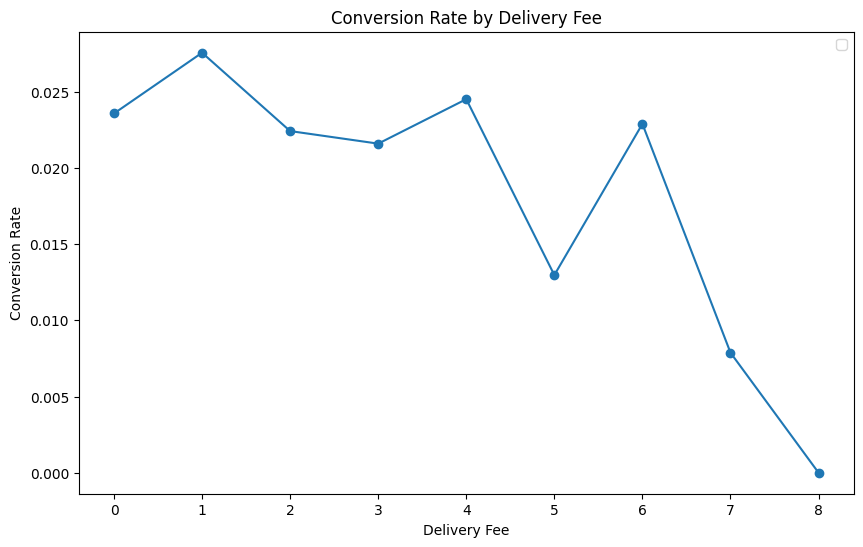

In [188]:
details['rounded'] = details['delivery_fee_listing'].round(0)

b = details.groupby('rounded').agg({'converted_order':'sum','shopId':'count'}).reset_index()

b['conversion'] = b['converted_order'] / b['shopId']

b = b[b['rounded'] <= 8]

plt.figure(figsize=(10,6))
plt.plot(b['rounded'], b['conversion'], marker='o')
plt.xlabel('Delivery Fee')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Delivery Fee')
plt.legend()
plt.show()

,delivery_fee_listing,converted_details_page,shopId,conversion
0,0.00,51920,434973,0.119364
1,0.39,4,62,0.064516
2,0.49,447,2698,0.165678
3,0.50,0,2,0.0
4,0.70,0,3,0.0
...,...,...,...,...
86,8.99,0,1,0.0
87,9.90,0,1,0.0
88,10.00,1,2,0.5
89,15.00,0,1,0.0


The 95th percentile of the delivery fees is: 5.79


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_78289/3404045467.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


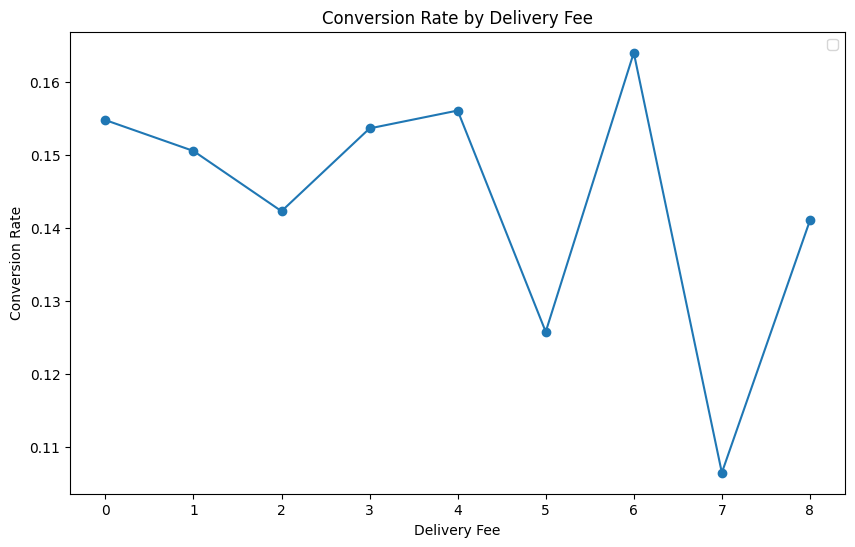

In [172]:
import numpy as np

# Assuming the previous steps to create the 'tt' DataFrame were already executed
tt = details.groupby(['session_key', 'delivery_fee']).agg({
    'converted_details_page': 'sum',
    'delivery_fee': 'count'
}).rename(columns={'delivery_fee': 'delivery_fee_count'}).reset_index()

tt['conversion'] = tt['converted_details_page'] / tt['delivery_fee_count']

tt['rounded_delivery_fee'] = tt['delivery_fee'].round(0)

#percentile_95_delivery_fee = np.percentile(tt['delivery_fee'], 99)

print(f"The 95th percentile of the delivery fees is: {percentile_95_delivery_fee}")

tt = tt[tt['rounded_delivery_fee'] <= 8]


conversion_rates = tt.groupby('rounded_delivery_fee')['conversion'].mean()

plt.figure(figsize=(10,6))
plt.plot(conversion_rates.index, conversion_rates.values, marker='o')
plt.xlabel('Delivery Fee')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Delivery Fee')
plt.legend()
plt.show()

In [156]:
details

,global_entity_id,session_key,perseus_session_id,shopId,category_id,delivery_fee_listing,delivery_fee_details,delivery_fee_order,delivery_fee,converted_details_page,converted_order
0,MJM_AT,+Qk1Mi7I1kFmwcjhFt2l5A==,1717239117528.7103557385.vgjvailvvn,eha9,027,1.79,NaN,NaN,1.79,0,0
1,MJM_AT,+iQIUo4+m4p+iy6L6Zv99A==,1717270402483.1604755945.shyuvqsfqx,va6r,064,2.49,0.00,NaN,2.49,1,0
2,MJM_AT,0Qw8hcC+sZxc+R1v9NFYuw==,1717265437448.4317314887.ixzgbiflec,aa4b,038,3.99,NaN,NaN,3.99,0,0
3,MJM_AT,0a+NGmsNMf/qRsWBlXDYVQ==,1717332755363.693426670240550323.nyf5kloWwB,y955,047,2.49,NaN,NaN,2.49,0,0
4,MJM_AT,0tc6Z1E04o+1hOfYyC688w==,1717260777157.2152830052.smcrlmuyth,lp35,092,0.00,NaN,NaN,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2191830,MJM_AT,jhsHQWMFN0aamzu7hRwhoA==,1717320526282.3057350118.mdplibcfck,ers4,174,0.00,NaN,NaN,0.00,0,0
2191831,MJM_AT,l4SlDNC/1gNtk1qJrZqYsA==,1717418384734.543613367233020483.kf0rkCHxkk,c4gs,174,2.49,2.49,NaN,2.49,1,0
2191832,MJM_AT,m2Gu9Ni1tp7PPsWh5ewkDg==,1717258947200.2756955006.rmxcgxowre,tteq,174,4.29,NaN,NaN,4.29,0,0
2191833,MJM_AT,qsYk3WtENwJpbPNdxnP2Iw==,1717325855504.3226868469.jvhgvmnnfl,iyo7,174,2.99,NaN,NaN,2.99,0,0


The 95th percentile of the delivery fees is: 5.79


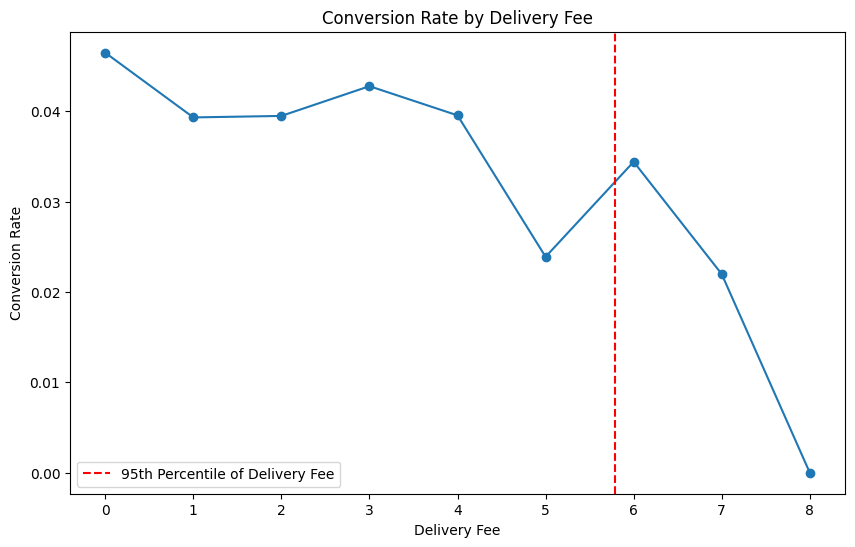

In [169]:
import numpy as np

# Assuming the previous steps to create the 'tt' DataFrame were already executed
tt = details.groupby(['session_key', 'delivery_fee']).agg({
    'converted_order': 'sum',
    'delivery_fee': 'count'
}).rename(columns={'delivery_fee': 'delivery_fee_count'}).reset_index()

tt['conversion'] = tt['converted_order'] / tt['delivery_fee_count']

tt['rounded_delivery_fee'] = tt['delivery_fee'].round(0)

# Calculate the 95th percentile of the delivery fees in the 'tt' DataFrame
#percentile_95_delivery_fee = np.percentile(tt['delivery_fee'], 99)

print(f"The 95th percentile of the delivery fees is: {percentile_95_delivery_fee}")

tt = tt[tt['rounded_delivery_fee'] <= 8]

# (Optional) If you want to include the percentile line in your plot:
# Step 2: Aggregate conversion rates by delivery fee across all sessions
conversion_rates = tt.groupby('rounded_delivery_fee')['conversion'].mean()

# Step 3: Plot the aggregated conversion rates
plt.figure(figsize=(10,6))
plt.plot(conversion_rates.index, conversion_rates.values, marker='o')
plt.axvline(x=percentile_95_delivery_fee, color='r', linestyle='--', label='95th Percentile of Delivery Fee')
plt.xlabel('Delivery Fee')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Delivery Fee')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with columns: 'session_id', 'delivery_fee', 'details_page_opened'
# Step 1: Calculate the conversion rate for each delivery fee in each session
df['conversion'] = df['details_page_opened'] / df['delivery_fee'].count()

# Step 2: Aggregate conversion rates by delivery fee across all sessions
conversion_rates = df.groupby('delivery_fee')['conversion'].mean()

# Step 3: Plot the aggregated conversion rates
plt.figure(figsize=(10,6))
plt.plot(conversion_rates.index, conversion_rates.values, marker='o')
plt.xlabel('Delivery Fee')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Delivery Fee')
plt.show()

In [112]:
import statsmodels.api as sm

# Example data
X = details[['delivery_fee_listing']] 
y = details['converted_details_page']

# Add a constant to the model (intercept term)
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Print the summary of the model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.371328
         Iterations 6
                             Logit Regression Results                             
Dep. Variable:     converted_details_page   No. Observations:              2231216
Model:                              Logit   Df Residuals:                  2231214
Method:                               MLE   Df Model:                            1
Date:                    Mon, 19 Aug 2024   Pseudo R-squ.:               6.453e-05
Time:                            15:40:29   Log-Likelihood:            -8.2851e+05
converged:                           True   LL-Null:                   -8.2857e+05
Covariance Type:                nonrobust   LLR p-value:                 4.594e-25
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.9394      0.004   -524.811   

Confusion Matrix:
 [[1958486       0]
 [ 272730       0]]
Accuracy: 0.8777662046166754


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.0
Recall: 0.0
F1-Score: 0.0
ROC-AUC Score: 0.5039110670787531


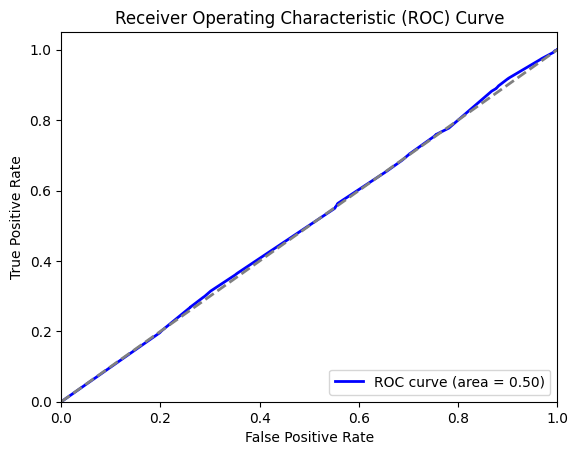

In [113]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming you've already defined X and y and fitted the model as in your example

# Predict the probabilities
y_pred_prob = result.predict(X)

# Convert probabilities to binary output (threshold = 0.5)
y_pred = np.where(y_pred_prob >= 0.5, 1, 0)

# Confusion Matrix
conf_matrix = confusion_matrix(y, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Accuracy
accuracy = accuracy_score(y, y_pred)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y, y_pred)
print("Precision:", precision)

# Recall
recall = recall_score(y, y_pred)
print("Recall:", recall)

# F1-Score
f1 = f1_score(y, y_pred)
print("F1-Score:", f1)

# ROC-AUC Score
roc_auc = roc_auc_score(y, y_pred_prob)
print("ROC-AUC Score:", roc_auc)

# Plotting the ROC Curve
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import statsmodels.api as sm

X = details[['delivery_fee_listing']] 
y = details['converted_details_page']

X = sm.add_constant(X)

model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

y_pred_prob = result.predict(X)
y_pred = [1 if x > 0.5 else 0 for x in y_pred_prob]

accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy}")

Optimization terminated successfully.
         Current function value: 0.371327
         Iterations 6
                             Logit Regression Results                             
Dep. Variable:     converted_details_page   No. Observations:              2231215
Model:                              Logit   Df Residuals:                  2231213
Method:                               MLE   Df Model:                            1
Date:                    Sun, 18 Aug 2024   Pseudo R-squ.:               6.458e-05
Time:                            23:28:27   Log-Likelihood:            -8.2851e+05
converged:                           True   LL-Null:                   -8.2856e+05
Covariance Type:                nonrobust   LLR p-value:                 4.408e-25
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.9394      0.004   -524.810   

    delivery_fee_rounded  converted_sessions  all_sessions
0                    0.0               33023         92332
1                    1.0               19261         65447
2                    2.0               41650        103976
3                    3.0               32917         86450
4                    4.0               30974         83861
5                    5.0               13380         52768
6                    6.0                1805          7620
7                    7.0                 420          1648
8                    8.0                  11            78
9                    9.0                   0             1
10                  10.0                   1             3
11                  15.0                   0             1
12                  45.0                   0             1


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_28452/1543314701.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = details.groupby('delivery_fee_rounded').apply(lambda x: pd.Series({


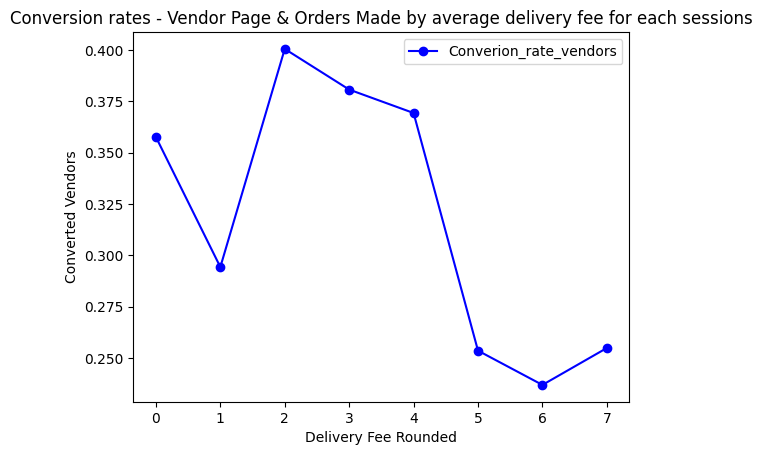

In [80]:
def count_sessions_with_value_1(group):
    return group[group['converted_details_page'] == 1]['session_key'].nunique()

def count_sessions_with_value_1_or_0(group):
    return group[group['converted_details_page'].isin([0, 1])]['session_key'].nunique()

details['delivery_fee_rounded'] = details['delivery_fee_listing'].round(0)

result = details.groupby('delivery_fee_rounded').apply(lambda x: pd.Series({
    'converted_sessions': count_sessions_with_value_1(x),
    'all_sessions': count_sessions_with_value_1_or_0(x)
})).reset_index()

print(result)

result['order_conversion'] = result['converted_sessions'] / result['all_sessions']

result = result[result['delivery_fee_rounded'] <= 7.0]

ax = result.plot(x='delivery_fee_rounded', y='order_conversion', label='Converion_rate_vendors', marker='o', color='blue')

ax.set_xlabel('Delivery Fee Rounded')
ax.set_ylabel('Converted Vendors')
plt.title('Conversion rates - Vendor Page & Orders Made by average delivery fee for each sessions')

plt.legend()

plt.show()

In [62]:
details

,global_entity_id,session_key,perseus_session_id,shopId,delivery_fee_listing,delivery_fee_details,delivery_fee_order,delivery_fee,converted_details_page,converted_order,Session_ID
0,MJM_AT,+0ILV2h/tKGNI0G9O3lUng==,1717319945372.0319162554.vtosygjfif,ef9s,3.50,NaN,NaN,3.50,0,0,+0ILV2h/tKGNI0G9O3lUng==
1,MJM_AT,+3aoiZvZiScxKgM/q/Jxgg==,1717431819357.8239955424.otyslnciqv,od1g,2.90,NaN,NaN,2.90,0,0,+3aoiZvZiScxKgM/q/Jxgg==
2,MJM_AT,+4xQ1s5o2hRSyAVv1wkf6A==,1717245472137.6209273579.dbdjqvkpdi,hbs0,2.59,NaN,NaN,2.59,0,0,+4xQ1s5o2hRSyAVv1wkf6A==
3,MJM_AT,+7+2nIyR6AmlhS3iqyRTMg==,1717440502418.3012858927.szviwqceaw,gizj,4.59,NaN,NaN,4.59,0,0,+7+2nIyR6AmlhS3iqyRTMg==
4,MJM_AT,+9cIgtGQT3qlGkcFfiqLrg==,1717344665431.4059915689.vkfgaigprk,pbh1,0.89,NaN,NaN,0.89,0,0,+9cIgtGQT3qlGkcFfiqLrg==
...,...,...,...,...,...,...,...,...,...,...,...
2245338,MJM_AT,zmnMUZs9rnF2nmVDh8xLoA==,1717338434590.6667019190.hvnfkhrlsc,t7jq,5.49,NaN,NaN,5.49,0,0,zmnMUZs9rnF2nmVDh8xLoA==
2245339,MJM_AT,zpwucXhYaACDhTy3Bdvbvw==,1717271495528.4687728997.yevtswzpyq,dagr,5.49,NaN,NaN,5.49,0,0,zpwucXhYaACDhTy3Bdvbvw==
2245340,MJM_AT,zpwucXhYaACDhTy3Bdvbvw==,1717271495528.4687728997.yevtswzpyq,ty0p,5.49,NaN,NaN,5.49,0,0,zpwucXhYaACDhTy3Bdvbvw==
2245341,MJM_AT,zuLFGNxGE8/H/2NFkCwFHQ==,1717248392864.7276095860.wsfollnbwm,x2zm,5.49,NaN,NaN,5.49,0,0,zuLFGNxGE8/H/2NFkCwFHQ==


In [43]:
a = details.groupby('delivery_fee_listing').agg({'delivery_fee_listing':'mean','delivery_fee_details' :'mean' }).reset_index()
a[['delivery_fee_listing','delivery_fee_details']] = a[['delivery_fee_listing','delivery_fee_details']].round(0)

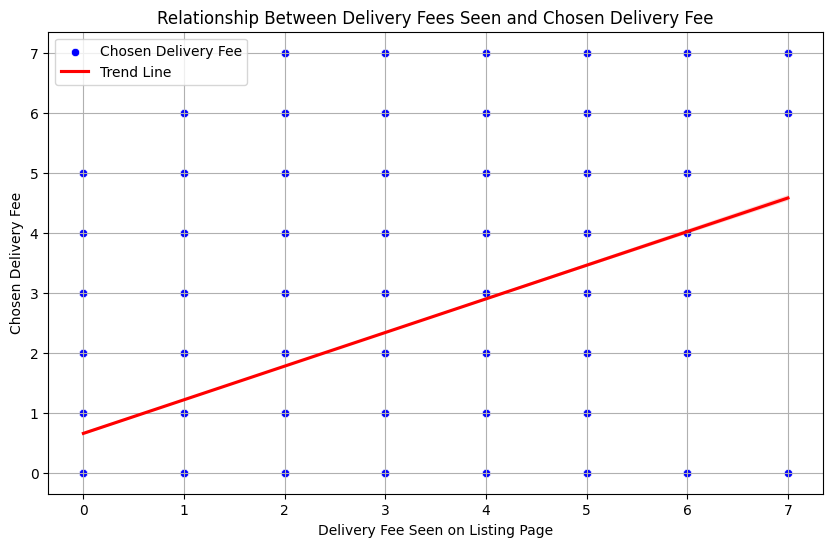

In [44]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x='delivery_fee_listing', y='delivery_fee_details', data=a, color='blue', label='Chosen Delivery Fee')

sns.regplot(x='delivery_fee_listing', y='delivery_fee_details', data=a, scatter=False, color='red', label='Trend Line')

plt.title('Relationship Between Delivery Fees Seen and Chosen Delivery Fee')
plt.xlabel('Delivery Fee Seen on Listing Page')
plt.ylabel('Chosen Delivery Fee')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
import statsmodels.api as sm

X = details[['delivery_fee_listing']] 
y = details['converted_order']

X = sm.add_constant(X)

model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

y_pred_prob = result.predict(X)
y_pred = [1 if x > 0.5 else 0 for x in y_pred_prob]

accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy}")

Optimization terminated successfully.
         Current function value: 0.112719
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:        converted_order   No. Observations:              2245343
Model:                          Logit   Df Residuals:                  2245341
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Aug 2024   Pseudo R-squ.:               0.0005944
Time:                        22:19:17   Log-Likelihood:            -2.5309e+05
converged:                       True   LL-Null:                   -2.5324e+05
Covariance Type:            nonrobust   LLR p-value:                 1.948e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -3.5990      0.008   -471.054      0.000      -3.614      -3.584

In [45]:
import pandas as pd
import statsmodels.formula.api as smf

details['Session_ID'] = details['session_key'].astype('category')

model = smf.mixedlm("converted_order ~ delivery_fee_listing", details, groups=details["Session_ID"]).fit()

print(model.summary())

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  converted_order
No. Observations:  2245343  Method:              REML           
No. Groups:        139012   Scale:               0.0215         
Min. group size:   1        Log-Likelihood:      1040614.6017   
Max. group size:   855      Converged:           Yes            
Mean group size:   16.2                                         
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept             0.052    0.000 161.256 0.000  0.051  0.052
delivery_fee_listing -0.001    0.000 -11.389 0.000 -0.001 -0.001
Group Var             0.005    0.001                            



In [116]:
a = details[~details['delivery_fee_details'].isna()]
a

,global_entity_id,session_key,perseus_session_id,shopId,delivery_fee_listing,delivery_fee_details,delivery_fee_order,delivery_fee,converted_details_page,converted_order,Session_ID
4,MJM_AT,+Ft0lm/dqlNVEdICwFuacQ==,1717431032518.4092645665.xamaqlxozh,la2b,0.89,0.89,NaN,0.89,1,0,+Ft0lm/dqlNVEdICwFuacQ==
6,MJM_AT,+LvoSMBXkt/q5kX1PNpXSA==,1717442956689.869687128503203721.VbGm4HMxOM,vi6h,2.90,2.90,NaN,2.90,1,0,+LvoSMBXkt/q5kX1PNpXSA==
11,MJM_AT,+kcLzhTO5nVpxuIH7diqcw==,1717339678554.6026138491.mmecvbkkmk,ieme,0.89,0.89,NaN,0.89,1,0,+kcLzhTO5nVpxuIH7diqcw==
31,MJM_AT,05C8lZ0CFqfvNn34nCzTXQ==,1717359078459.3160932328.ruttvebmid,jc5w,2.79,2.79,2.79,2.79,1,1,05C8lZ0CFqfvNn34nCzTXQ==
33,MJM_AT,0DZJ1lRTbiKT7JbvqI1kPQ==,1717341241334.754888519623656937.1z5KeI4Oi1,d4cg,0.49,0.49,0.00,0.49,1,1,0DZJ1lRTbiKT7JbvqI1kPQ==
...,...,...,...,...,...,...,...,...,...,...,...
2231166,MJM_AT,t2C6aPyoVidY8rqB8HahCw==,1717433831553.724902515705781416.CmwmlCC5U0,ow0f,5.49,5.49,NaN,5.49,1,0,t2C6aPyoVidY8rqB8HahCw==
2231174,MJM_AT,uBsMIfVM7WbyW3VoyNkn/Q==,1717352230335.787748329999977941.WLivahfnMJ,kgo1,5.49,5.49,NaN,5.49,1,0,uBsMIfVM7WbyW3VoyNkn/Q==
2231194,MJM_AT,x3vywQd3GbSYTUiREsKh8g==,1717439104106.5870516170.obccwpgrle,b755,5.49,5.49,NaN,5.49,1,0,x3vywQd3GbSYTUiREsKh8g==
2231206,MJM_AT,ys5zKjxMLcbS30e/HCLaAg==,1717430292569.2362566269.pmlofuazin,xvrh,5.49,5.49,NaN,5.49,1,0,ys5zKjxMLcbS30e/HCLaAg==


In [131]:
    export RPY2_CFFI_MODE=ABI
pip install pymer4

SyntaxError: invalid syntax (3629803387.py, line 1)

In [122]:
import pandas as pd
from pymer4.models import Lmer
import numpy as np

model = Lmer("converted_order ~ delivery_fee_listing + (1 | Session_ID)", data=details, family='binomial')
result = model.fit()

print(result.summary())

ModuleNotFoundError: No module named 'pymer4'

In [ ]:
print("Log-Likelihood (Mixed Effects):", model.llf)
print("AIC (Mixed Effects):", result.aic)

fixed_model = sm.Logit(df['OpenMenu'], sm.add_constant(df[['DeliveryFee']])).fit()
print("Log-Likelihood (Fixed Effects):", fixed_model.llf)
print("AIC (Fixed Effects):", fixed_model.aic)

In [118]:
random_effects = model.random_effects

random_effects_df = pd.DataFrame.from_dict(random_effects, orient='index')
random_effects_df.reset_index(inplace=True)
random_effects_df.rename(columns={'index': 'Session_ID'}, inplace=True)

print(random_effects_df.head())

                 Session_ID     Group
0  ++0u55IlaYPsh5wAfZTNXg== -0.113280
1  ++1DJl6j/Zjf25F4UmwaCw== -0.103782
2  ++AopSze1dRD4kppw9bQOg==  0.263736
3  ++BNgWbN4JF9Jz+7ds4gMQ==  0.028237
4  ++CJk+xZjkr4TiYGJQgylA== -0.202830


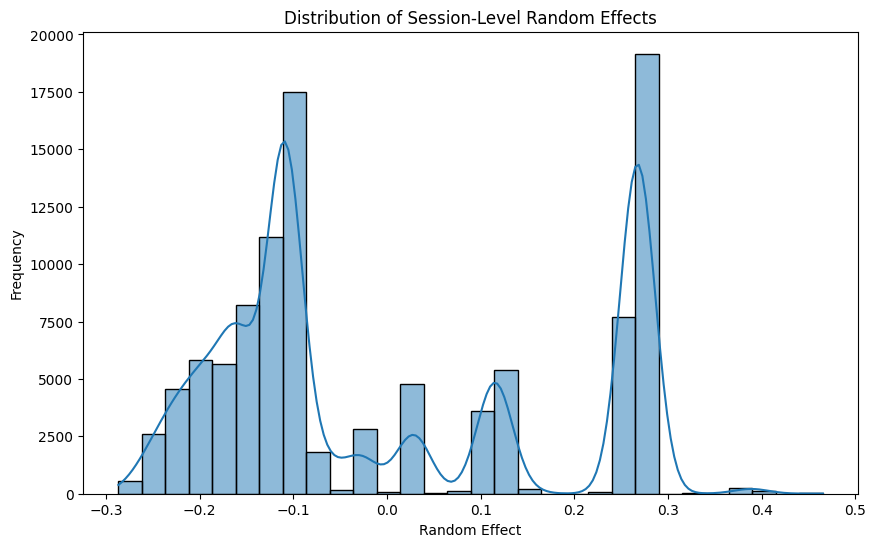

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(random_effects_df['Group'], bins=30, kde=True)
plt.title('Distribution of Session-Level Random Effects')
plt.xlabel('Random Effect')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

details['Session_ID'] = details['session_key'].astype('category')

model = smf.mixedlm("converted_order ~ delivery_fee_listing", details, groups=details["Session_ID"]).fit()

print(model.summary())

In [36]:
# # Sort the random effects by Session_ID for a cleaner plot
# random_effects_df = random_effects_df.sort_values('Group')

# # Plot random effects by Session_ID
# plt.figure(figsize=(12, 6))
# sns.scatterplot(x='Session_ID', y='Group', data=random_effects_df, hue='Group', palette='viridis', legend=False)
# plt.xticks(rotation=90)
# plt.title('Random Effects by Session')
# plt.xlabel('Session ID')
# plt.ylabel('Random Effect')
# plt.show()

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_28452/2746231963.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='Session_ID', y='Random_Effect', data=random_effects_df, hue='Random_Effect', palette='viridis', legend=False)


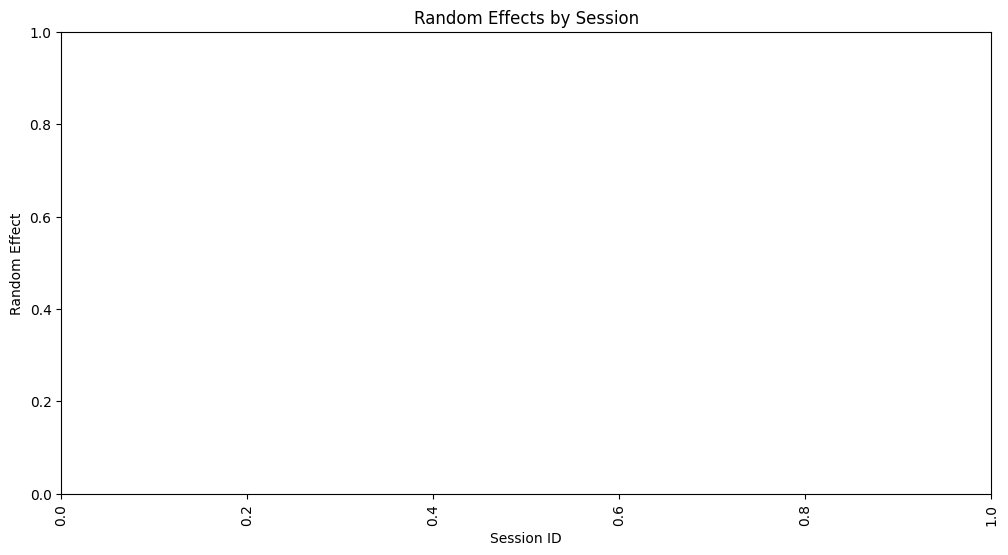

In [19]:
random_effects_df = random_effects_df.sort_values('Random_Effect')

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Session_ID', y='Random_Effect', data=random_effects_df, hue='Random_Effect', palette='viridis', legend=False)
plt.xticks(rotation=90)
plt.title('Random Effects by Session')
plt.xlabel('Session ID')
plt.ylabel('Random Effect')
plt.show()

<Figure size 1000x600 with 0 Axes>

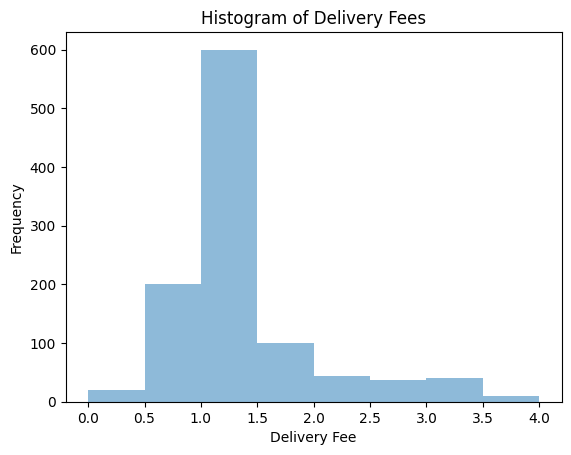

In [9]:
# Plot histogram
plt.figure(figsize=(10, 6))
match_details_df.hist(column='delivery_fee', bins=[0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0], alpha=0.5)
plt.xlabel('Delivery Fee')
plt.ylabel('Frequency')
plt.title('Histogram of Delivery Fees')
plt.grid(False)
plt.show()

In [10]:
match_details_df['delivery_fee_rounded'] = match_details_df['delivery_fee'].round(0)
match_details_df

# Group by 'Group'
grouped = match_details_df.groupby('delivery_fee_rounded')

# Count the number of rows with value 1 in 'Value' column for each group
count_ones_v = grouped['vendor_page_opened'].apply(lambda x: (x == 1).sum())
count_ones_o = grouped['transacted'].apply(lambda x: (x == 1).sum())

# Count the total number of rows for each group
total_counts = grouped.size()

# Combine counts into a single DataFrame
result = pd.DataFrame({
    'converted_vendors': count_ones_v,
    'converted_orders': count_ones_o,
    'total_sessions': total_counts
}).reset_index()

result['conversion_rate_vendor_page'] = result['converted_vendors']/result['total_sessions']
result['conversion_rate_orders'] = result['converted_orders']/result['total_sessions']


#match_details_df.hist(column = 'delivery_fee', bins=[0, 0.5, 1.0, 1.5,2.0,2.5,3.0,3.5,4.0], alpha=0.5)



result.plot(x = 'delivery_fee_rounded',y = 'conversion_rate_vendor_page')

KeyError: 'Column not found: vendor_page_opened'

In [11]:
# Create the plot
ax = result.plot(x='delivery_fee_rounded', y='conversion_rate_vendor_page', label='Converion_rate_vendors', marker='o', color='blue')

# Plot the normalized conversion rate orders on the same axis
result.plot(x='delivery_fee_rounded', y='conversion_rate_orders', label='Conversion_Rate_Orders', marker='o', color='orange', ax=ax)

# Add labels and title
ax.set_xlabel('Delivery Fee Rounded')
ax.set_ylabel('Converted Vendors')
plt.title('Conversion rates - Vendor Page & Orders Made by average delivery fee for each sessions')

# Add a legend to distinguish between the two lines
plt.legend()

# Show the plot
plt.show()

NameError: name 'result' is not defined

In [ ]:
result

,delivery_fee_rounded,converted_vendors,converted_orders,total_sessions,conversion_rate_vendor_page,conversion_rate_orders
0,0.0,352281,200394,913146,0.385788,0.219455
1,1.0,100169,43607,113966,0.878938,0.382632
2,2.0,35442,11444,37055,0.956470,0.308838
3,3.0,15148,3790,16257,0.931783,0.233130
4,4.0,3133,791,3382,0.926375,0.233885
5,5.0,817,115,1132,0.721731,0.101590
6,6.0,265,6,320,0.828125,0.018750
7,7.0,36,0,94,0.382979,0.000000


In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import statsmodels.api as sm
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# # Step 2: Prepare the data
# # Make sure 'transacted' is binary. Assuming it's already in binary form.
# X = result['delivery_fee_rounded']
# y = result['conversion_rate_orders']

# # Adding a constant to the model (the intercept term)
# X = sm.add_constant(X)

# # Step 3: Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Step 4: Train the model
# logit_model = sm.Logit(y_train, X_train)
# result_mo = logit_model.fit()

# # Step 5: Evaluate the model
# print(result_mo.summary())

# # Predict on the test set
# y_pred = result_mo.predict(X_test)
# y_pred_class = (y_pred > 0.5).astype(int)  # Convert probabilities to binary outcomes

# # Evaluation metrics
# accuracy = accuracy_score(y_test, y_pred_class)
# conf_matrix = confusion_matrix(y_test, y_pred_class)
# class_report = classification_report(y_test, y_pred_class)

# print(f"Accuracy: {accuracy:.2f}")
# print("Confusion Matrix:")
# print(conf_matrix)
# print("Classification Report:")
# print(class_report)

# # Visualize the confusion matrix
# plt.figure(figsize=(8, 6))
# plt.imshow(conf_matrix, cmap='Blues', alpha=0.7)
# plt.title('Confusion Matrix')
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.colorbar()
# plt.xticks([0, 1], ['Not Transacted', 'Transacted'])
# plt.yticks([0, 1], ['Not Transacted', 'Transacted'])

# # Annotate confusion matrix
# thresh = conf_matrix.max() / 2.
# for i in range(conf_matrix.shape[0]):
#     for j in range(conf_matrix.shape[1]):
#         plt.text(j, i, format(conf_matrix[i, j], 'd'),
#                  horizontalalignment="center",
#                  color="white" if conf_matrix[i, j] > thresh else "black")

# plt.show()

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Step 2: Prepare the data
# Extract the independent variable and dependent variable
X = result['delivery_fee_rounded']
#y = result['conversion_rate_vendor_page']
y = result['conversion_rate_orders']

# Adding a constant to the model (the intercept term)
X = sm.add_constant(X)

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the model
linear_model = sm.OLS(y_train, X_train)
result_mod = linear_model.fit()

# Step 5: Evaluate the model
print(result_mod.summary())

# Predict on the test set
y_pred = result_mod.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Step 6: Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(X['delivery_fee_rounded'], y, color='blue', label='Data Points')
plt.plot(X_test['delivery_fee_rounded'], y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Delivery Fee')
plt.ylabel('Transacted')
plt.title('Linear Regression')
plt.legend()
plt.show()


NameError: name 'result' is not defined

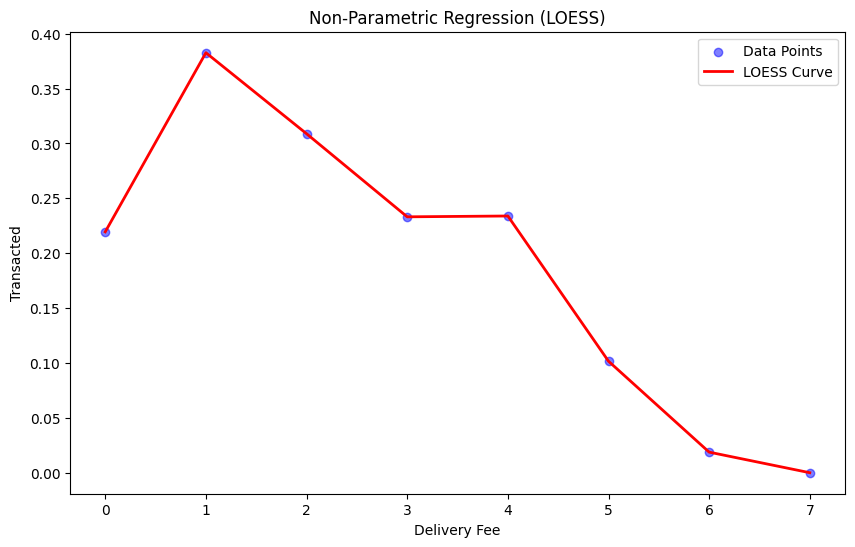

In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess


# Step 2: Prepare the data
X = result['delivery_fee_rounded'].values
y = result['conversion_rate_orders'].values

# Step 3: Fit the model
# Using LOESS with a fraction parameter to determine the amount of smoothing
# The fraction is the proportion of the data used to estimate each y-value
loess_result = lowess(y, X, frac=0.2)  # Adjust the frac value for more or less smoothing

# Extracting the smoothed values
x_loess = loess_result[:, 0]
y_loess = loess_result[:, 1]

# Step 4: Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data Points', alpha=0.5)
plt.plot(x_loess, y_loess, color='red', linewidth=2, label='LOESS Curve')
plt.xlabel('Delivery Fee')
plt.ylabel('Transacted')
plt.title('Non-Parametric Regression (LOESS)')
plt.legend()
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     8.250
Date:                Wed, 14 Aug 2024   Prob (F-statistic):             0.0454
Time:                        16:04:46   Log-Likelihood:                 7.7385
No. Observations:                   6   AIC:                            -11.48
Df Residuals:                       4   BIC:                            -11.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3179      0.062      5.160      0.0

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


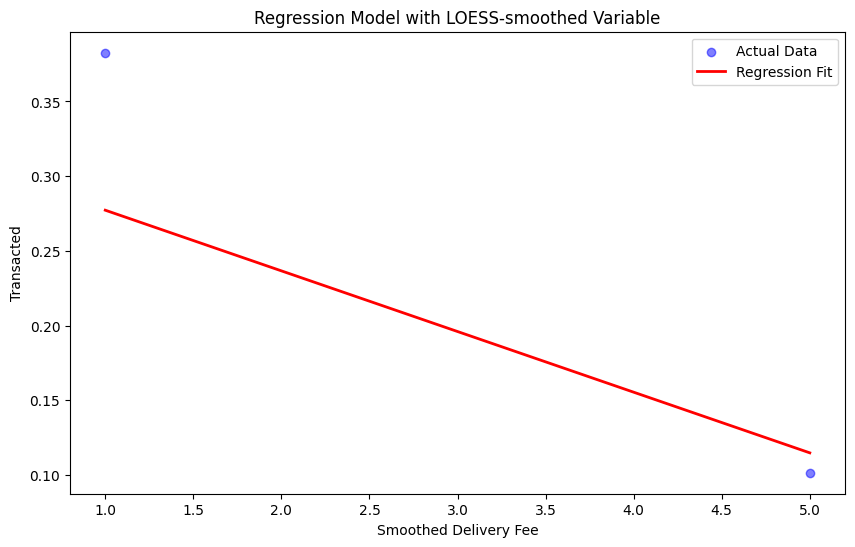

In [234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm
from sklearn.model_selection import train_test_split


# Extract the independent variable and the dependent variable
X = result['delivery_fee_rounded'].values
y = result['conversion_rate_orders'].values

# Step 1: Apply LOESS smoothing to the variable
loess_result = lowess(y, X, frac=0.2)  # Adjust the frac value for more or less smoothing

# Extracting the smoothed values
X_loess = loess_result[:, 0]
y_loess = loess_result[:, 1]

# Step 2: Split the data (using the smoothed variable as the new predictor)
X_train, X_test, y_train, y_test = train_test_split(X_loess, y, test_size=0.2, random_state=42)

# Adding a constant term for the intercept
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Step 3: Fit the regression model using the smoothed variable
model = sm.OLS(y_train, X_train_sm)
results = model.fit()

# Print the summary of the regression model
print(results.summary())

# Predict using the model
y_pred = results.predict(X_test_sm)

# Step 4: Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Data', alpha=0.5)
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Fit')
plt.xlabel('Smoothed Delivery Fee')
plt.ylabel('Transacted')
plt.title('Regression Model with LOESS-smoothed Variable')
plt.legend()
plt.show()

In [235]:
loess_result

array([[0.        , 0.2194545 ],
       [1.        , 0.38263166],
       [2.        , 0.30883821],
       [3.        , 0.23313034],
       [4.        , 0.23388527],
       [5.        , 0.10159011],
       [6.        , 0.01875   ],
       [7.        , 0.        ]])

In [236]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split


# Extract the independent variable and the dependent variable
X_original = result['delivery_fee_rounded'].values
y = result['conversion_rate_vendor_page'].values

# Add a constant term for the intercept
X_original_sm = sm.add_constant(X_original)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_original_sm, y, test_size=0.2, random_state=42)

# Fit the regression model using the original variable
model_original = sm.OLS(y_train, X_train)
results_original = model_original.fit()

# Print the summary of the regression model
print("Original Variable Regression Results:")
print(results_original.summary())

Original Variable Regression Results:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.249
Method:                 Least Squares   F-statistic:                  0.003989
Date:                Wed, 14 Aug 2024   Prob (F-statistic):              0.953
Time:                        16:04:46   Log-Likelihood:               -0.22420
No. Observations:                   6   AIC:                             4.448
Df Residuals:                       4   BIC:                             4.032
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [237]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Apply LOESS smoothing to the variable
loess_result = lowess(y, X_original, frac=0.2)
X_loess = loess_result[:, 0]
y_loess = loess_result[:, 1]

# Fit a regression model using the smoothed variable
X_loess_sm = sm.add_constant(X_loess)
X_train_loess, X_test_loess, y_train_loess, y_test_loess = train_test_split(X_loess_sm, y, test_size=0.2, random_state=42)

model_loess = sm.OLS(y_train_loess, X_train_loess)
results_loess = model_loess.fit()

# Print the summary of the regression model with LOESS-smoothed variable
print("LOESS-smoothed Variable Regression Results:")
print(results_loess.summary())

LOESS-smoothed Variable Regression Results:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.249
Method:                 Least Squares   F-statistic:                  0.003989
Date:                Wed, 14 Aug 2024   Prob (F-statistic):              0.953
Time:                        16:04:46   Log-Likelihood:               -0.22420
No. Observations:                   6   AIC:                             4.448
Df Residuals:                       4   BIC:                             4.032
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
